In [1]:
from transformers import ViTImageProcessor, ViTForImageClassification

import torch, torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import time
from torchsummary import summary

import numpy as np
import matplotlib.pyplot as plt
import os

from PIL import Image

In [2]:
processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224')
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')

In [3]:
dataset = 'celebrities'

train_directory = os.path.join(dataset, 'train')
valid_directory = os.path.join(dataset, 'val')

bs = 32

num_classes = 17

data = {
    'train': datasets.ImageFolder(root=train_directory, transform=processor),
    'valid': datasets.ImageFolder(root=valid_directory, transform=processor)
}

idx_to_class = {v: k for k, v in data['train'].class_to_idx.items()}
print(idx_to_class)

train_data_size = len(data['train'])
valid_data_size = len(data['valid'])

train_data_loader = DataLoader(data['train'], batch_size=bs, shuffle=True)
valid_data_loader = DataLoader(data['valid'], batch_size=bs, shuffle=True)

{0: 'Angelina Jolie', 1: 'Brad Pitt', 2: 'Denzel Washington', 3: 'Hugh Jackman', 4: 'Jennifer Lawrence', 5: 'Johnny Depp', 6: 'Kate Winslet', 7: 'Leonardo DiCaprio', 8: 'Megan Fox', 9: 'Natalie Portman', 10: 'Nicole Kidman', 11: 'Robert Downey Jr', 12: 'Sandra Bullock', 13: 'Scarlett Johansson', 14: 'Tom Cruise', 15: 'Tom Hanks', 16: 'Will Smith'}


In [4]:
train_data_size, valid_data_size

(1441, 254)

In [5]:
model

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=7

In [6]:
for param in model.parameters():
    param.requires_grad = False

In [7]:
model.classifier = nn.Linear(768, num_classes)

In [8]:
model.classifier.add_module("softmax", nn.LogSoftmax(dim = 1))

In [9]:
model

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=7

In [10]:
loss_func = nn.NLLLoss()
optimizer = optim.Adam(model.parameters())
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)

In [11]:
def train_and_validate(model, loss_criterion, optimizer, epochs=25):
    start = time.time()
    history = []
    best_acc = 0.0

    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))
        
        model.train()
        
        train_loss = 0.0
        train_acc = 0.0
        
        valid_loss = 0.0
        valid_acc = 0.0
        
        for i, (inputs, labels) in enumerate(train_data_loader):

            optimizer.zero_grad()
            
            outputs = model(inputs['pixel_values'][0])
            
            loss = loss_criterion(outputs.logits, labels)
            loss.backward()
            
            optimizer.step()
            
            train_loss += loss.item() * bs
            
            ret, predictions = torch.max(outputs.logits, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            
            train_acc += acc.item() * bs
            
        with torch.no_grad():
            model.eval()

            for j, (inputs, labels) in enumerate(valid_data_loader):

                outputs = model(inputs['pixel_values'][0])

                loss = loss_criterion(outputs.logits, labels)

                valid_loss += loss.item() * bs

                ret, predictions = torch.max(outputs.logits, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                acc = torch.mean(correct_counts.type(torch.FloatTensor))

                valid_acc += acc.item() * bs


        avg_train_loss = train_loss/train_data_size 
        avg_train_acc = train_acc/train_data_size


        avg_valid_loss = valid_loss/valid_data_size 
        avg_valid_acc = valid_acc/valid_data_size

        history.append([avg_train_loss, avg_valid_loss, avg_train_acc, avg_valid_acc])
                
        epoch_end = time.time()
    
        print("Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation : Loss : {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(epoch+1, avg_train_loss, avg_train_acc*100, avg_valid_loss, avg_valid_acc*100, epoch_end-epoch_start))
        
        #print("Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation : Loss : {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(epoch+1, avg_train_loss, avg_train_acc*100, avg_valid_loss, avg_valid_acc*100, epoch_end-epoch_start))
            
    return model, history

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

num_epochs = 3
trained_model, history = train_and_validate(model, loss_func, optimizer, num_epochs)

torch.save(history, dataset+'_history.pt')

Epoch: 1/3
Epoch : 001, Training: Loss: -6.7977, Accuracy: 30.9507%, 
		Validation : Loss : -13.0509, Accuracy: 36.8504%, Time: 239.6780s
Epoch: 2/3
Epoch : 002, Training: Loss: -20.6344, Accuracy: 44.5524%, 
		Validation : Loss : -25.6877, Accuracy: 37.2178%, Time: 235.6328s
Epoch: 3/3
Epoch : 003, Training: Loss: -34.2685, Accuracy: 46.4261%, 
		Validation : Loss : -38.1932, Accuracy: 35.7743%, Time: 226.8154s


In [21]:
def predict(model, test_image_name):

    test_image = Image.open(test_image_name)
    plt.imshow(test_image)
    
    test_image_tensor = processor(images=test_image, return_tensors="pt")
    
    
    with torch.no_grad():
        model.eval()
        out = model(**test_image_tensor)
        ps = torch.exp(out.logits)
        topk, topclass = ps.topk(3, dim=1)
        for i in range(3):
            print("Predcition", i+1, ":", idx_to_class[topclass.numpy()[0][i]], ", Score: ", topk.numpy()[0][i])

Predcition 1 : Denzel Washington , Score:  6.0429203e+19
Predcition 2 : Leonardo DiCaprio , Score:  6.082969e+16
Predcition 3 : Hugh Jackman , Score:  3.037454e+16


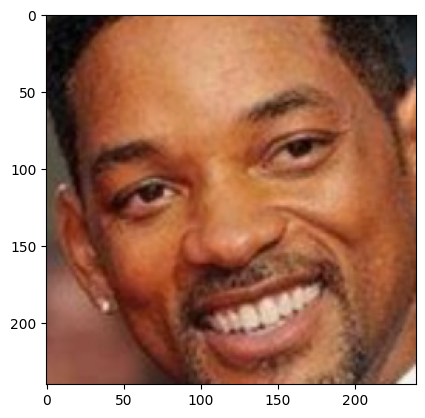

In [25]:
predict(trained_model, 'celebrities/test/Will Smith/095_8a2dfab4.jpg')

Predcition 1 : Johnny Depp , Score:  2.8530428e+16
Predcition 2 : Robert Downey Jr , Score:  2027544100000000.0
Predcition 3 : Leonardo DiCaprio , Score:  255566400000000.0


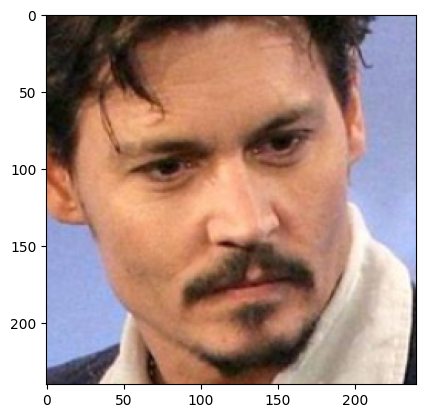

In [40]:
predict(trained_model, 'celebrities/test/Johnny Depp/095_233dc3f2.jpg')

Predcition 1 : Scarlett Johansson , Score:  4.612685e+18
Predcition 2 : Angelina Jolie , Score:  4.476173e+16
Predcition 3 : Megan Fox , Score:  3.1307784e+16


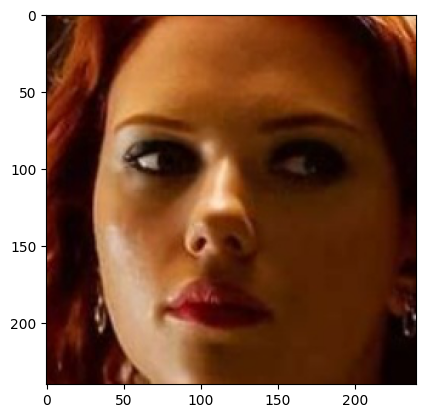

In [24]:
predict(trained_model, 'celebrities/test/Scarlett Johansson/196_08de561a.jpg')